<a href="https://colab.research.google.com/github/Kyezil/cs231n-solutions/blob/master/assignment1/features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

### Download and extract the required files

In [1]:
%cd
!rm -rf cs231n-solutions
!git clone https://github.com/Kyezil/cs231n-solutions.git
%cd cs231n-solutions/
!git checkout A1Q4
%cd assignment1
!ls

/root
Cloning into 'cs231n-solutions'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 72 (delta 12), reused 34 (delta 9), pack-reused 23
Unpacking objects: 100% (72/72), done.
/root/cs231n-solutions
Note: checking out 'A1Q4'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 53c20c3 update .py files with classifiers
/root/cs231n-solutions/assignment1
cs231n		knn.ipynb      svm.ipynb
features.ipynb	softmax.ipynb  two_layer_net.ipynb


### Initial setup

In [0]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
!cd cs231n/datasets/ && bash get_datasets.sh


--2019-02-18 18:28:48--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  3.90MB/s    in 27s     

2019-02-18 18:29:15 (5.99 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [20]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [15]:
# Use the validation set to tune the learning rate and regularization strength
from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.logspace(-9.75, -9.25, 5)
regularization_strengths = np.logspace(3.5,4.5,5)

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
  for rs in regularization_strengths:
    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)

    y_train_pred = svm.predict(X_train_feats)
    train_acc = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val_feats)
    val_acc = np.mean(y_val == y_val_pred)
    if val_acc > best_val:
      best_val = val_acc
      best_svm = svm
    results[(lr,rs)] = train_acc, val_acc
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 46.435462
iteration 100 / 1500: loss 22.736716
iteration 200 / 1500: loss 14.039081
iteration 300 / 1500: loss 10.848043
iteration 400 / 1500: loss 9.677554
iteration 500 / 1500: loss 9.248217
iteration 600 / 1500: loss 9.090626
iteration 700 / 1500: loss 9.032527
iteration 800 / 1500: loss 9.011634
iteration 900 / 1500: loss 9.003722
iteration 1000 / 1500: loss 9.000961
iteration 1100 / 1500: loss 8.999950
iteration 1200 / 1500: loss 8.999535
iteration 1300 / 1500: loss 8.999260
iteration 1400 / 1500: loss 8.999470
iteration 0 / 1500: loss 49.335731
iteration 100 / 1500: loss 23.803833
iteration 200 / 1500: loss 14.427733
iteration 300 / 1500: loss 10.991431
iteration 400 / 1500: loss 9.729617
iteration 500 / 1500: loss 9.267671
iteration 600 / 1500: loss 9.098655
iteration 700 / 1500: loss 9.035396
iteration 800 / 1500: loss 9.012166
iteration 900 / 1500: loss 9.004209
iteration 1000 / 1500: loss 9.001190
iteration 1100 / 1500: loss 8.999989
iteration 1200 / 

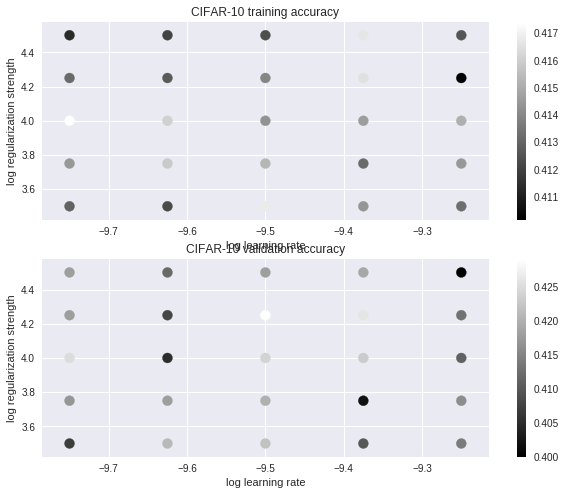

In [16]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [17]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.429


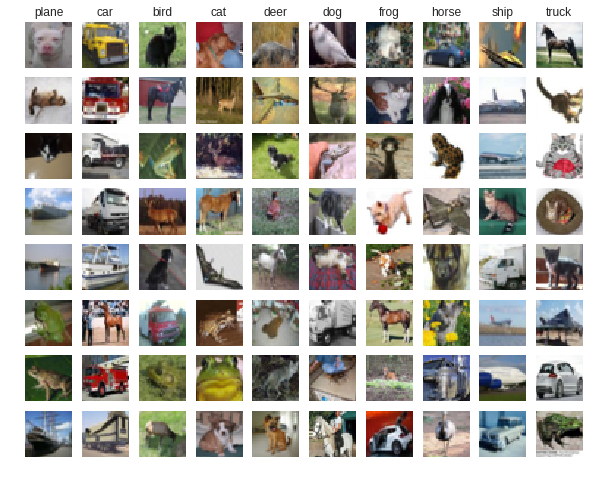

In [18]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense??
No, they don't look  similar.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [21]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [29]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
results = {}
best_val = -1

learning_rates = [0.1e-1, 9e-1]
regularization_strengths = [1e-3, 1e-5]
hidden_size = [600,1100]

for i in range(0, 10):
    print("\nIteration no.: %d\n" % i)
    # sample a learning rate, reg rate and hidden size from the given range
    learning_rate = (learning_rates[1] - learning_rates[0]) \
                    * np.random.random_sample() + learning_rates[0]

    reg = (regularization_strengths[1] - regularization_strengths[0]) \
          * np.random.random_sample() + regularization_strengths[0]

    h = np.random.randint(low=hidden_size[0], high=hidden_size[1])
    
    print("LEARNING RATE: %e" % learning_rate)
    print("REG STRENGTH: %e" % reg)
    print("HIDDEN SIZE: %d" % h)
    
    net = TwoLayerNet(input_dim, h, num_classes)

    net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=learning_rate, learning_rate_decay=0.95,
            reg=reg, verbose=True)
    
    # predict values
    y_train_pred = net.predict(X_train_feats)
    training_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = net.predict(X_val_feats)
    validation_accuracy = np.mean(y_val == y_val_pred)
    
    # store the data in results
    results[(learning_rate, reg, h)] = (training_accuracy, validation_accuracy)
    
    # Check if the result we got is the best one we've achieved until now
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_net = net
        
    
# Print out results.
for lr, reg, h in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, h)]
    print('lr %e reg %e hidden size %d train accuracy: %f val accuracy: %f' % (
                lr, reg, h, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################


Iteration no.: 0

LEARNING RATE: 2.334719e-01
REG STRENGTH: 3.457883e-04
HIDDEN SIZE: 943
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.945839
iteration 200 / 1000: loss 1.502853
iteration 300 / 1000: loss 1.398270
iteration 400 / 1000: loss 1.450443
iteration 500 / 1000: loss 1.316485
iteration 600 / 1000: loss 1.297020
iteration 700 / 1000: loss 1.287437
iteration 800 / 1000: loss 1.273368
iteration 900 / 1000: loss 1.196972

Iteration no.: 1

LEARNING RATE: 1.318642e-01
REG STRENGTH: 3.551625e-04
HIDDEN SIZE: 912
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.296090
iteration 200 / 1000: loss 1.912281
iteration 300 / 1000: loss 1.715175
iteration 400 / 1000: loss 1.419071
iteration 500 / 1000: loss 1.424576
iteration 600 / 1000: loss 1.373383
iteration 700 / 1000: loss 1.289065
iteration 800 / 1000: loss 1.219025
iteration 900 / 1000: loss 1.292150

Iteration no.: 2

LEARNING RATE: 6.068515e-01
REG STRENGTH: 2.031531e-04
HIDDEN SIZE: 618
iteration 0

In [30]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.575
